Matthew O'Malley-Nichols

omallema@oregonstate.edu

CS 325 Algorithms Spring 2023

#Particle Swarm Optimization

##Background

Particle Swarm Optimization (PSO) is a optimization method developed in 1995. PSO works by having "particles" search a problem space for an objective function, attempting to find the minimum. These particles communicate with each other by affecting the velocity of particles with worse solutions. Therefore, each particle has its own personal best solution to an objective function, and the swarm itself has a personal best solution. Next, lets look at the pseudocode of the standard particle swarm optimization.

##Pseudocode - Standard PSO

Before we look at the pseudocode, lets define a few things. An objective function represents the goal of an optimization or cost problem. A fitness function is a type of objective function that returns how close a current solution is to the desired solution. Our fitness and objective functions will be the same, as we only have a single objective of minimizing the objective function. We will define fitness as the value returned from plugging our particle's position into our fitness function. Now lets jump into the pseudocode.

In [2]:
for each particle i = 1, ..., S do
    Initialize the particle's position with a uniformly distributed random vector: xi ~ U(blo, bup)
    Initialize the particle's best known position to its initial position: pi ← xi
    if f(pi) < f(g) then
        update the swarm's best known position: g ← pi
    Initialize the particle's velocity: vi ~ U(-|bup-blo|, |bup-blo|)
while a termination criterion is not met do:
    for each particle i = 1, ..., S do
        for each dimension d = 1, ..., n do
            Pick random numbers: rp, rg ~ U(0,1)
            Update the particle's velocity: vi,d ← w vi,d + φp rp (pi,d-xi,d) + φg rg (gd-xi,d)
        Update the particle's position: xi ← xi + vi
        if f(xi) < f(pi) then
            Update the particle's best known position: pi ← xi
            if f(pi) < f(g) then
                Update the swarm's best known position: g ← pi
                
Source: https://en.wikipedia.org/wiki/Particle_swarm_optimization

SyntaxError: unterminated string literal (detected at line 2) (2133149841.py, line 2)

The first step in PSO is to initialize each particle in the set of particles. Each particle is randomly given a position within the bounds of the objective function, and the particle's best known position is set to this position. Next the fitness of the particle's best known position is compared to the fitness of the swarm's best known position. If the particle's fitness is less than the swarm's, the swarm's fitness is updated with the particle's. Finally, we initialize the particle's velocity to be a random vector within the bounds of the objective function or a vector of 0's.


Next we have the main loop, which runs until a termination criteria is met. This criteria is typically a designated number of iterations, but, if we know the minimum of the objective function, the end condition could be when the minimum is found. While this condition is not met, each particle is iterated over. For every dimension in the problem space, the velocity in that dimension is updated with the formula:

velocity = (weight * current velocity) + (cognitive coefficient * random number between 0 and 1) * (distance to personal best position) + (social coefficient * random number between 0 and 1) * (distance to the global best position). 

The weight, also known as inertia, affects how strongly the particle wants to continue along their current velocity. The cognitive coefficient affects how much the particle is drawn to their own personal best location, while the social coefficient affects how much the particle is drawn to the swarm's best location. Next, the particle's position is set to be the current position plus the velocity.

We next compare the fitness of the current position to the fitness of the particle's best known position, updating the particles best known position if a smaller value is found. Then, we update the swarm's best position if its fitness is greater than the fitness of the particle's position. 

####Time Complexity

P = number of particles

D = number of dimensions in problem space

T = termination criteria

While the time complexity of particle swarm optimization can be incredibly varied depending on implementation, we can see that this implementation starts with having P particles initialized. Then a main loop runs that is tightly bound to the (termination condition) times the (number of particles) times the (number of dimensions). The rest of the logic is computations and comparisons done in constant time. Therefore, the time complexity of this standard implementation is O(P * D * T  + P). 

##Implementation

Lets begin our implementation of PSO. We will be minimizing a function called Ackley's, a optimization benchmark known for its various local optima. Ackley's function only has one global minimum: x=0 and y=0, which we will be trying to reach.

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib widget

Lets begin by importing our needed libraries. We will be using numpy for our vectors and for our math functions.

In [2]:
class Particle():
    """Represents a particle"""
    dimensions = 2
    # Inertial weight
    weight = 1 
    # Social and cognitive coefficients.
    # Cognitive makes a particle care more about its own findings
    # Social makes a particle care more about the swarm's findings
    social_coefficient = 1.5 
    cognitive_coefficient = 1.5
    # Upper and lower bounds of the problem
    upper_bound = 5
    lower_bound = -5
    # Swarm's best known position
    gbest_pos = [upper_bound] * dimensions
    # Target minimum values
    target = [0,0]
    error = 1e-6

    @classmethod
    def decrement_weight(cls):
        """Decrement the weight/inertia of all particles"""
        if cls.weight > 0.3:
            cls.weight = cls.weight - 0.01

    @classmethod
    def setup(cls, weight:float=1.0, social:float=1.5, cognitive:float=1.5, dimensions:int=2, upper:float=5.0, lower:float=-5.0, target:list=[0,0], error:float=1e-6) -> None:
        """Setup the swarm space"""
        cls.weight = weight
        cls.social_coefficient = social
        cls.cognitive_coefficient = cognitive
        cls.dimensions = dimensions
        cls.gbest_pos = [upper] * dimensions
        cls.upper_bound = upper
        cls.lower_bound = lower
        cls.target = target
        cls.error = error
        assert len(cls.gbest_pos) == cls.dimensions

    @classmethod
    def within_target_error(cls) -> bool:
        """Returns true if gbest_pos is within the designated target error"""
        for d in range(cls.dimensions):
            if cls.gbest_pos[d] < cls.target[d] + cls.error:
                if cls.gbest_pos[d] > cls.target[d] - cls.error:
                    return True 
        return False 

    @classmethod
    def fitness(cls, position):
        """Ackley"""
        x = position[0]
        y = position[1]
        #return x**2 + y**2
        return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * 
          np.pi * x)+np.cos(2 * np.pi * y))) + np.e + 20

    def __init__(self) -> None:
        # Set position. Makes vector with dimensions Particle.dimensions
        self.position = np.random.uniform(low=Particle.lower_bound, high=Particle.upper_bound, size=Particle.dimensions)
        # Set best known pos
        self.pbest_pos = self.position
        self.update_gbest_pos()
        # Initialize velocity within bounds.
        self.velocity = np.random.uniform(low=Particle.lower_bound, high=Particle.upper_bound, size=Particle.dimensions)

    def __str__(self) -> str:
        """Returns the position and velocity of the particle"""
        return f"My current position is: {self.position}. My pbest is: {self.pbest_pos}. My velocity is: {self.velocity}."

    def update_position(self) -> None:
        """Set the particle's position based on current position and velocity"""
        self.position = self.position + self.velocity

    def update_pbest_pos(self) -> bool:
        """Update particle's best known pos with its current position, if its better. Returns True/false if updated/not."""
        if self.fitness(self.position) < self.fitness(self.pbest_pos):
            self.pbest_pos = self.position
            return True
        return False

    def update_gbest_pos(self) -> bool:
        """Updates gbest based on particle index"""
        if self.fitness(self.pbest_pos) < self.fitness(Particle.gbest_pos):
            Particle.gbest_pos = self.pbest_pos 
            return True
        return False

    def update_velocity(self) -> None: 
        """Update the particle's velocity in each dimension"""
        for d in range(len(self.velocity)):
            # Inertia * velocity
            inertial_velocity =  Particle.weight * self.velocity[d]
            # Find distance to personal best pos 
            dist_pbest = self.pbest_pos[d] - self.position[d]
            # Find distance to global best pos
            dist_gbest = Particle.gbest_pos[d] - self.position[d]
            # Set cognitive constant
            p_const = Particle.cognitive_coefficient * np.random.uniform(low=0.001, high=1)
            # Set the social constant
            g_const = Particle.social_coefficient * np.random.uniform(low=0.001, high=1)
            # Set velocity in given dimension
            final_velocity = inertial_velocity + p_const * dist_pbest + g_const * dist_gbest 
            self.velocity[d] = final_velocity

    def enforce_bounds(self) -> None:
        """When the position is outside of bounds, it is set in bounds. When a velocity is outside, it is set to 0"""
        for d in range(len(self.position)):
            if self.position[d] > Particle.upper_bound:
                self.position[d] = Particle.upper_bound
                continue
            if self.position[d] < Particle.lower_bound:
                self.position[d] = Particle.lower_bound
        for d in range(len(self.velocity)):
            if self.velocity[d] > Particle.upper_bound:
                self.velocity[d] = 0 
                continue
            if self.velocity[d] < Particle.lower_bound:
                self.velocity[d] = 0 

    def search(self) -> bool:
        """A single particle's search for minimum"""
        self.update_velocity()
        self.update_position()
        self.enforce_bounds()
        if self.update_pbest_pos():
            if self.update_gbest_pos():
                return Particle.within_target_error()
        return False

We will be using a class called Particle to represent each particle. The class itself represents the swarm of particles and the problem space, including the fitness function

In [8]:
def setup_plot(type3d:bool=True):
    """Based off of https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/
    and https://towardsdatascience.com/swarm-intelligence-coding-and-visualising-particle-swarm-optimisation-in-python-253e1bd00772"""
    l = Particle.lower_bound
    u = Particle.upper_bound
    x, y = np.array(np.meshgrid(np.linspace(l,u,100), np.linspace(l,u,100)))
    z = Particle.fitness([x, y])
    x_min = x.ravel()[z.argmin()]
    y_min = y.ravel()[z.argmin()]
    fig =plt.figure(figsize=(8,6))
    if type3d:
        ax = fig.add_subplot(111, projection='3d')
        ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
        ax.plot_wireframe(x,y,z, color='red', rcount=100, ccount=100, linewidth=0.2)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        return fig, ax
    else:
        plt.imshow(z, extent=[l, u, l, u], origin='lower', cmap='viridis', alpha=0.5)
        plt.colorbar()
        contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
        plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
        return fig

The logic for setting up a contour plot is based off of machinelearningmastery's contour plot, linked above.

Gbestpos is: [ 0.00893866 -0.34199575], in 50 iterations


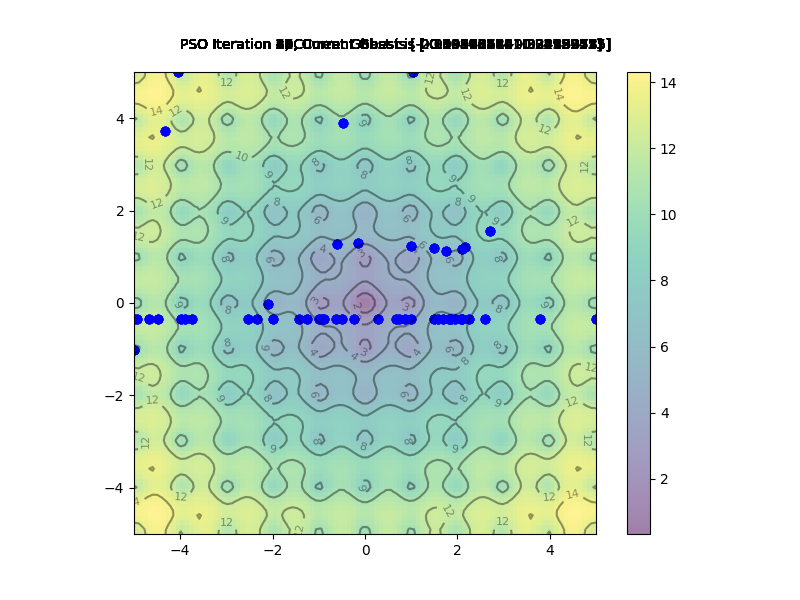

In [9]:
def particle_swarm_optimization(social=1.5, cognitive=1.5, weight=1.0, dec_weight=True, n_particles=5, iterations=50, type3d:bool=True):
    # Swarm Setup
    Particle.setup(social=social, cognitive=cognitive, weight=weight, dimensions=2, upper=5.0, lower=-5.0, target=[0,0], error=1e-6)
    particles = [Particle()] * n_particles
    found_target = False
    # Matplotlib setup call
    if type3d:
        fig, ax = setup_plot(type3d=True)
    else:
        fig = setup_plot(type3d=False)
    artists = []

    i = 0
    while found_target == False and i < iterations:
        for particle in particles:
            found_target = particle.search()
        if dec_weight == True:
            Particle.decrement_weight
        i += 1

        # Matplotlib frames for animation
        x_positions = [particles[n].position[0] for n in range(n_particles)]
        y_positions = [particles[n].position[1] for n in range(n_particles)]
        if type3d:
            fitness_vals = [Particle.fitness([particles[n].position[0], particles[n].position[1]]) for n in range(n_particles)]
            frame = ax.scatter3D(x_positions,y_positions, fitness_vals, c='b')
            title = ax.text(x=-4, y=4, z=20, s=f"PSO Iteration {i}, Current Gbest is {Particle.gbest_pos}")
        else:
            frame = plt.scatter(x_positions, y_positions, c='b')
            title = plt.text(x=-4, y=5.5, s=f"PSO Iteration {i}, Current Gbest is {Particle.gbest_pos}")
        artists.append([frame, title])

    print(f"Gbestpos is: {Particle.gbest_pos}, in {i} iterations")
    anim = animation.ArtistAnimation(fig, artists)
    plt.show()

    
particle_swarm_optimization(type3d=False)

The main termination loop is set to end when a suitable target is found, or when the iterations succeed a specified amount